<font size="4"> Importuje pakiety</font> 

In [3]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from word2number import w2n
import math

<font size="5"> Pobieram i wyświetlam dane ustawień szachowych i ich resultatów </font>


In [4]:
# wczytywanie danych
chess_df = pd.read_csv("chess_king_rook_dataset.csv")

In [4]:
# wyświetlanie danych
pp.ProfileReport(chess_df, title='report', explorative=True).to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


<AxesSubplot:xlabel='result', ylabel='Count'>

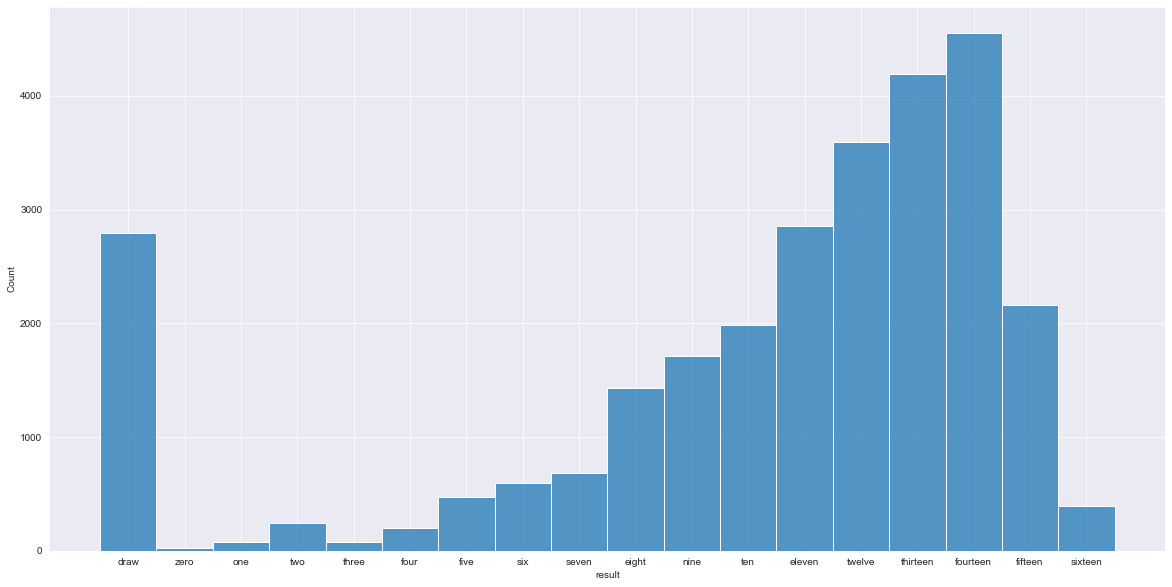

In [5]:
%matplotlib inline
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(20,10)) 
sns.histplot( chess_df["result"].astype(str), kde=False,ax = axes) 

Sprawdzam czy w danych istnieje dublikacja ustawień planszy

In [6]:
# Zliczam ile ustawień pionków się powtarza
new_df = chess_df[["white_king_file", 'white_king_rank', "white_rook_file", 'white_rook_rank', 'black_king_file', 'black_king_rank']]
new_df = new_df.groupby(new_df.columns.tolist(),as_index=False).size().sort_values('size')
new_df = new_df.apply(lambda x : True
            if x['size'] > 1 else False, axis = 1)

# Count number of True in the series
num_rows = len(new_df[new_df == True].index)
print(num_rows) 

0


<font size="4"> Sprawdzam wyniki w zależności od pozycji poszczególnych pionków</font>

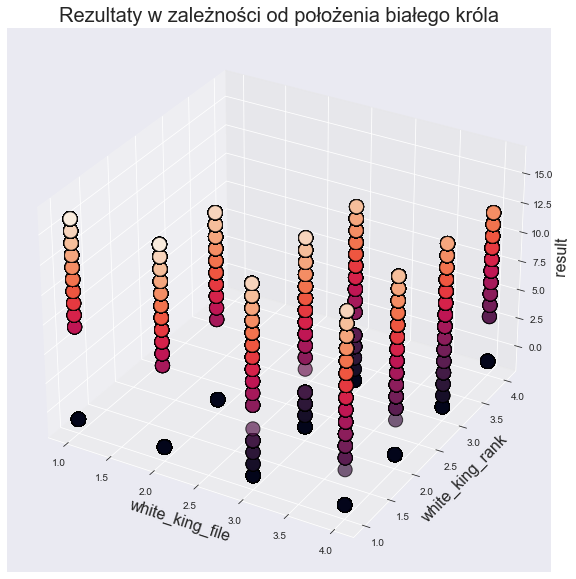

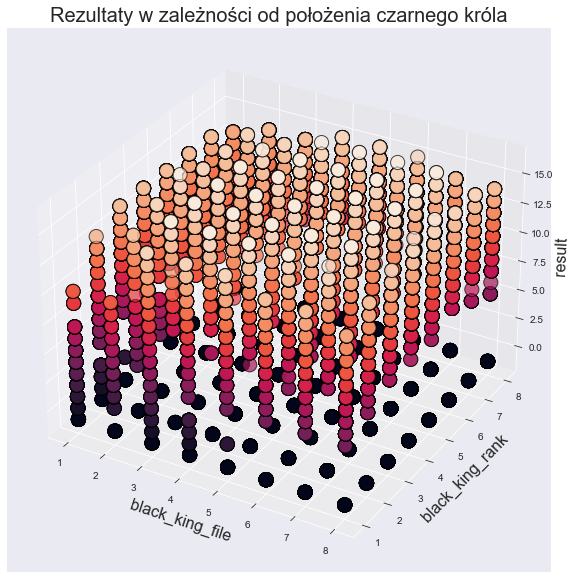

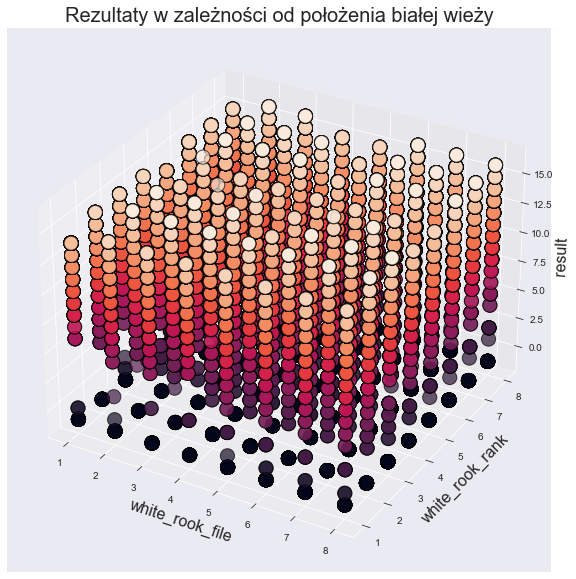

In [7]:

def result2int(result: str) -> int:
    if result == 'draw':
        return -1
    return w2n.word_to_num(result)

def result_3D_plot(file: str, rank: str, title: str) -> None:
    white_king_file = chess_df[file].apply(lambda x : ord(str(x)) - ord('a') + 1)
    white_king_rank = chess_df[rank]
    white_king_result = chess_df["result"].apply(lambda x : result2int(x))

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(white_king_file, white_king_rank, white_king_result,
               linewidths=1, alpha=.7,
               edgecolor='k',
               s = 200,
               c=white_king_result)
    plt.title(title, fontsize=20)
    ax.set_xlabel(file, fontsize=16)
    ax.set_ylabel(rank, fontsize=16)
    ax.set_zlabel("result", fontsize=16)
    plt.show()



result_3D_plot("white_king_file", "white_king_rank", "Rezultaty w zależności od położenia białego króla")

result_3D_plot("black_king_file", "black_king_rank", "Rezultaty w zależności od położenia czarnego króla")

result_3D_plot("white_rook_file", "white_rook_rank", "Rezultaty w zależności od położenia białej wieży")




<font size="4"> Sprawdzam rozkłady pionków na planszy w przypadku zwycięstwa białych</font>

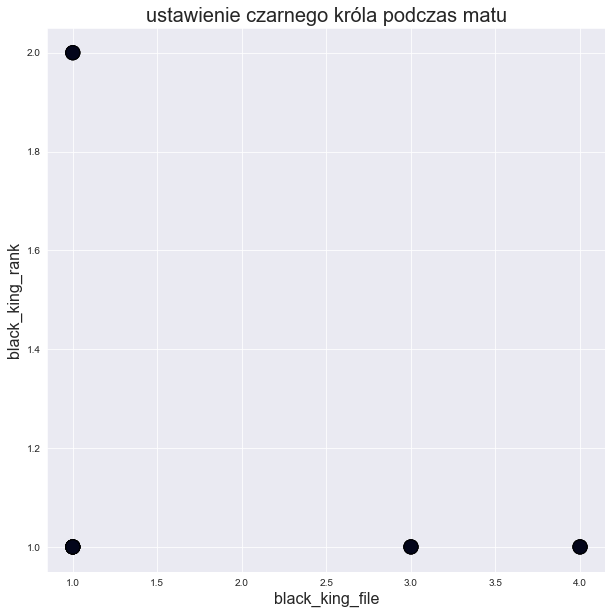

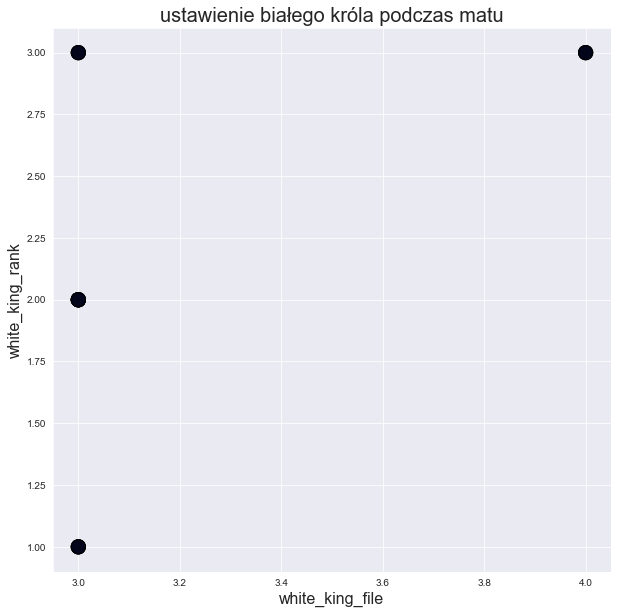

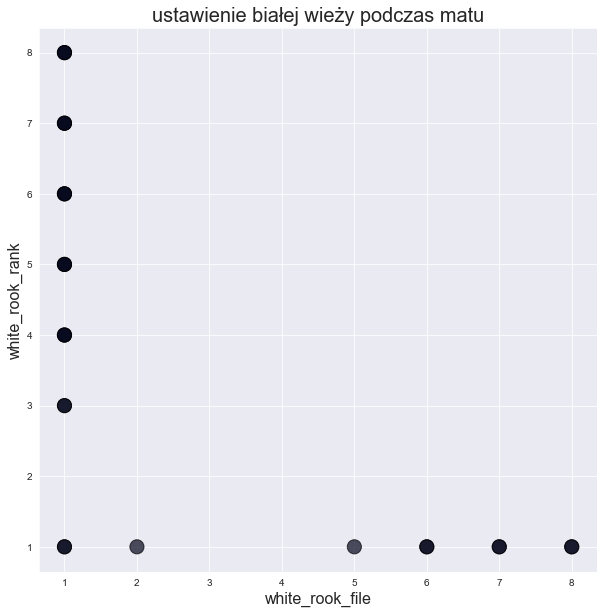

In [8]:
def mat_3D_plot(file: str, rank: str, title: str) -> None:
    rslt_df = chess_df[chess_df['result'] == "zero"]
    white_king_file = rslt_df[file].apply(lambda x : ord(str(x)) - ord('a') + 1)
    white_king_rank = rslt_df[rank]
    white_king_result = rslt_df["result"].apply(lambda x : result2int(x))

    fig = plt.figure(figsize=(10,10))
    plt.scatter(white_king_file, white_king_rank,
               linewidths=1, alpha=.7,
               edgecolor='k',
               s = 200,
               c=white_king_result)
    plt.xlabel(file, fontsize=16)
    plt.ylabel(rank, fontsize=16)
    plt.title(title, fontsize=20)
    plt.show()

mat_3D_plot("black_king_file", "black_king_rank", "ustawienie czarnego króla podczas matu")

mat_3D_plot("white_king_file", "white_king_rank", "ustawienie białego króla podczas matu")

mat_3D_plot("white_rook_file", "white_rook_rank", "ustawienie białej wieży podczas matu")

<font size="6"> Wnioski: </font>
 <ul>
  <li> Nie ma zbędnych kolumn </li>
  <li> Ilość danych rezultatów rosnie od 0 do 14, następnie jest nagły spadek</li>
  <li> Wartości wyniku 13 i 14 wybijają się na tle reszty</li>
  <li> Z wykresu korelacji można zauważyć, że największy wpływ na rezultat ma położenie białego króla na szachownicy, mniejsze ma położenie czarnego króla a najmniejsze położenie wieży </li>
  <li> Dane nie zawierają powtórzeń </li>
  <li> Dane nie zawierają powtórzeń </li>
  <li> Mat jest możliwy tylko wtedy gdy czarny król i biała wieża są na skraju szachownicy </li>
  <li> W większości pozycji startowych możemy rozegrać partie tak by zmatować czarnego króla </li>
</ul>  
</font>

<font size="6"> Analiza rezultatów w zależności od położenia poszczególnych pionków na szachownicy</font>

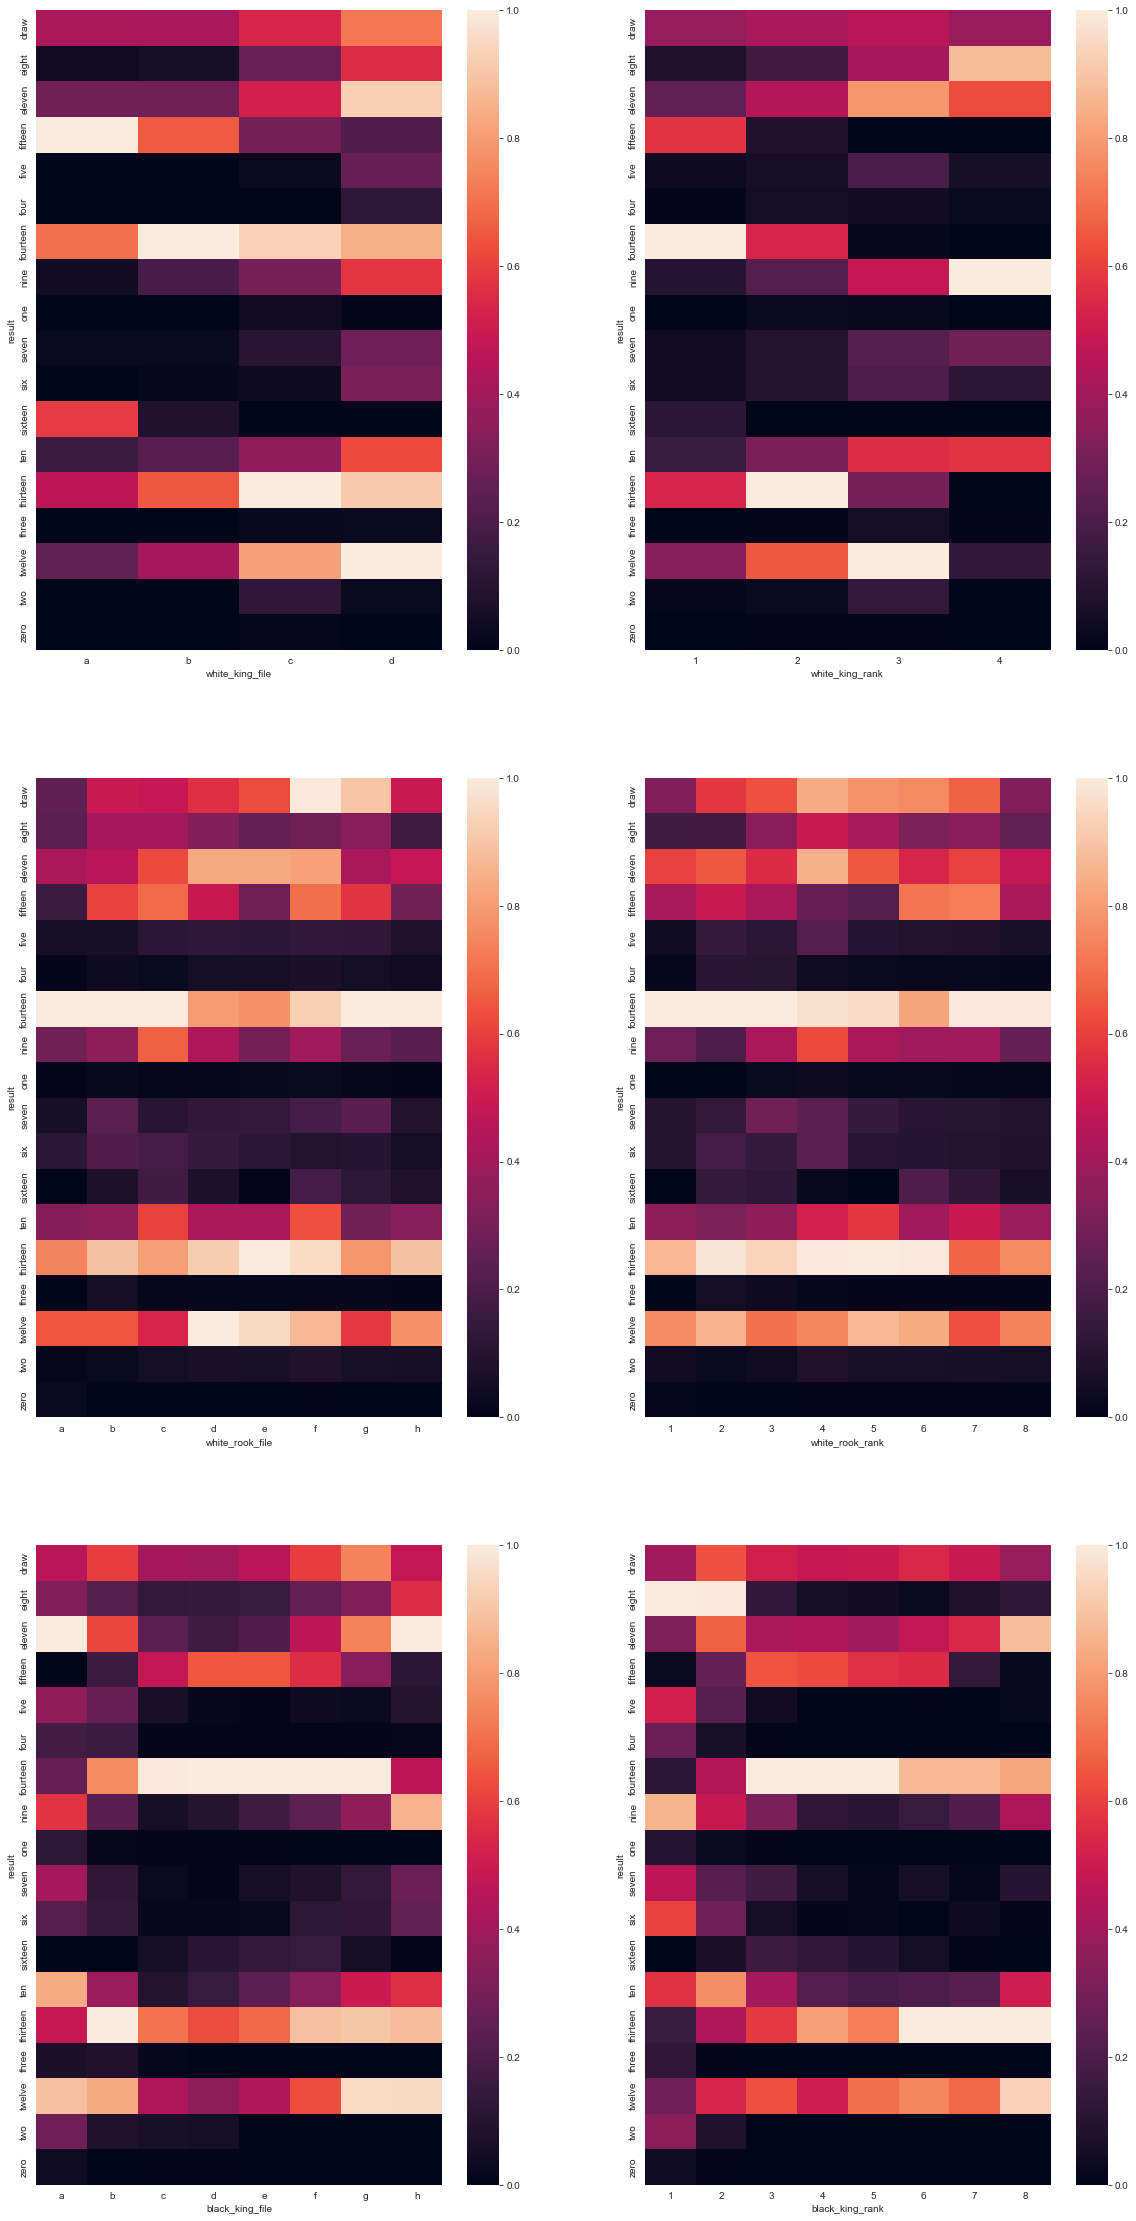

In [9]:
i = 0
j = 0
fig, axes = plt.subplots(3, 2, sharex=False, figsize=(20,40)) 
for colname in chess_df.columns:
    if colname not in ["result"]:
        df= pd.crosstab(chess_df["result"], chess_df[colname])
        normalized_df=(df)/(df.max()+df.min())
        sns.heatmap(normalized_df, vmin=0, vmax=1, ax = axes[i,j])
        j+=1
        if(j>=2):
            i+=1
            j=0

plt.show()  

<font size="4"> Wnioski: Z koleracji ciężko wysnuć jakiekolwiek wnioski, korzystne może być stworzenie dodatkowych kolumn które mogłyby mieć większy wpływ na wynik</font>


<font size="6"> Wprowadzenie zależności między pionkami do bazy danych</font>

Koleracja między poszczególnymi wynikami jest nikła, spróbujemy więc wprowadzić dodatkowe zależności między pionkami a ich pozycją względem innych pionków jak i względem poszczególnych pól na szachownicy.

In [10]:
def distance_from_black_king_to_center():
    def distance(row):
        x = 0
        if(row["black_king_rank"] > 4):
            x =  row["black_king_rank"] - 5
        else:
            x =  4 - row["black_king_rank"]

        positin = ord(row["black_king_file"]) - ord('a') + 1
        y = 0
        if(positin > 4):
            y =  positin - 5
        else:
            y =  4 - positin
        return math.sqrt(math.pow(x,2) + math.pow(y,2))
    return chess_df.apply(distance , axis=1)

chess_df = chess_df.assign( distance_from_black_king_to_center = distance_from_black_king_to_center())

In [11]:
def distance_from_white_king_to_white_rook():
    def distance(row):
        x = row["white_king_rank"] - row["white_rook_rank"]
        y = ord(row["white_king_file"]) - ord(row["white_rook_file"])
        return math.sqrt(math.pow(x,2) + math.pow(y,2))
    return chess_df.apply(distance , axis=1)

chess_df = chess_df.assign( distance_from_white_king_to_white_rook = distance_from_white_king_to_white_rook())


In [12]:
def distance_from_pion_to_position(pion_name, position_file, position_rank):
    def distance(row):
        x = row[pion_name+"_rank"] - position_rank
        y = ord(row[pion_name+"_file"]) - ord(position_file)
        return math.sqrt(math.pow(x,2) + math.pow(y,2))
    return chess_df.apply(distance , axis=1)

chess_df = chess_df.assign( distance_from_white_rook_to_extreme_rug  = distance_from_pion_to_position("white_rook", 'a', 1))


In [13]:
def taxicab_metric(x1, x2, y1, y2):
    return abs(x1-y1) + abs(x2-y2)

# wczytywanie danych
chess_df.info()
chess_df['black_king_file'] = chess_df['black_king_file'].apply(lambda x : ord(str(x)) - ord('a') + 1)
chess_df['white_king_file'] = chess_df['white_king_file'].apply(lambda x : ord(str(x)) - ord('a') + 1)
chess_df['white_rook_file'] = chess_df['white_rook_file'].apply(lambda x : ord(str(x)) - ord('a') + 1)

chess_df = chess_df.assign( b_king_rook_dist= taxicab_metric(chess_df['black_king_file'], chess_df['black_king_rank'], chess_df['white_rook_file'], chess_df['white_rook_rank']))
chess_df = chess_df.assign( b_king_start_dist = taxicab_metric(chess_df['black_king_file'], chess_df['black_king_rank'], 1, 1))
chess_df = chess_df.assign( w_king_start_dist = taxicab_metric(chess_df['white_king_file'], chess_df['white_king_rank'], 1, 1))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28056 entries, 0 to 28055
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   white_king_file                          28056 non-null  object 
 1   white_king_rank                          28056 non-null  int64  
 2   white_rook_file                          28056 non-null  object 
 3   white_rook_rank                          28056 non-null  int64  
 4   black_king_file                          28056 non-null  object 
 5   black_king_rank                          28056 non-null  int64  
 6   result                                   28056 non-null  object 
 7   distance_from_black_king_to_center       28056 non-null  float64
 8   distance_from_white_king_to_white_rook   28056 non-null  float64
 9   distance_from_white_rook_to_extreme_rug  28056 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usag

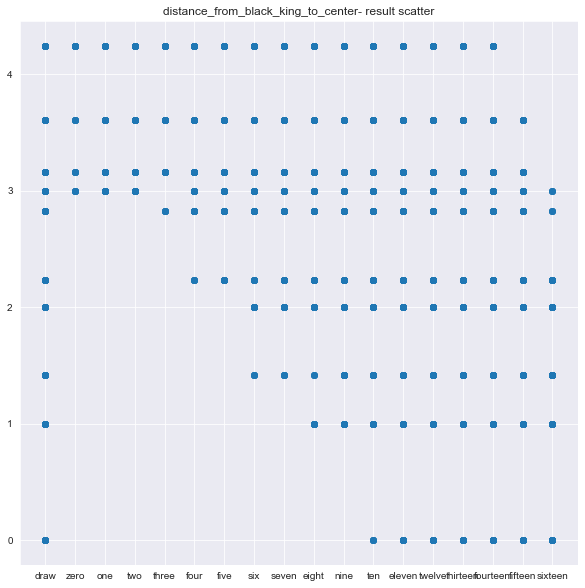

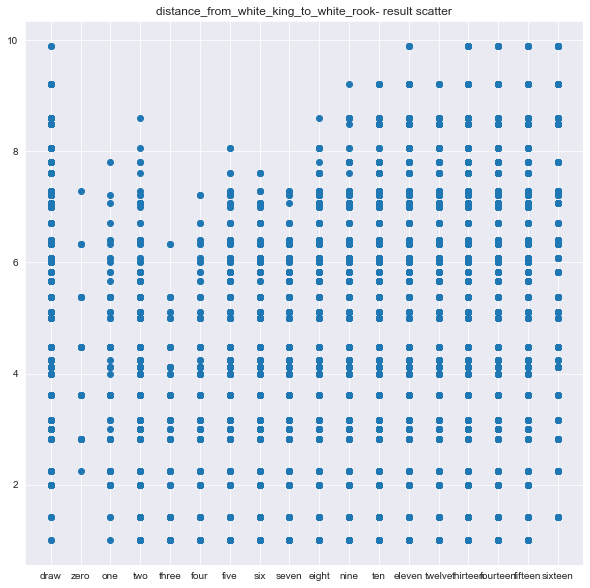

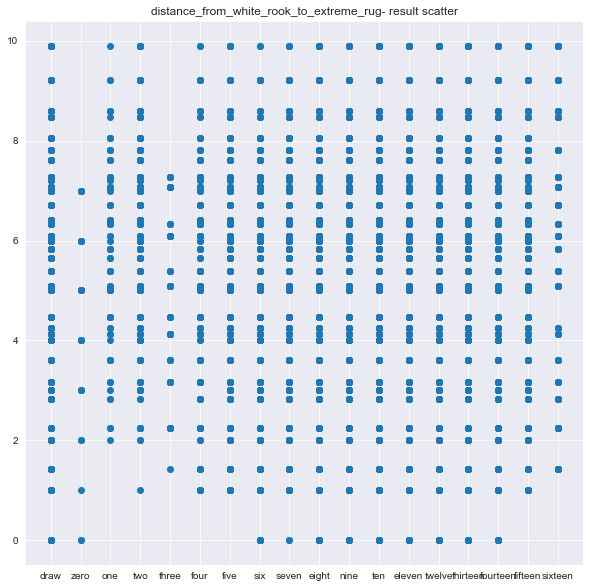

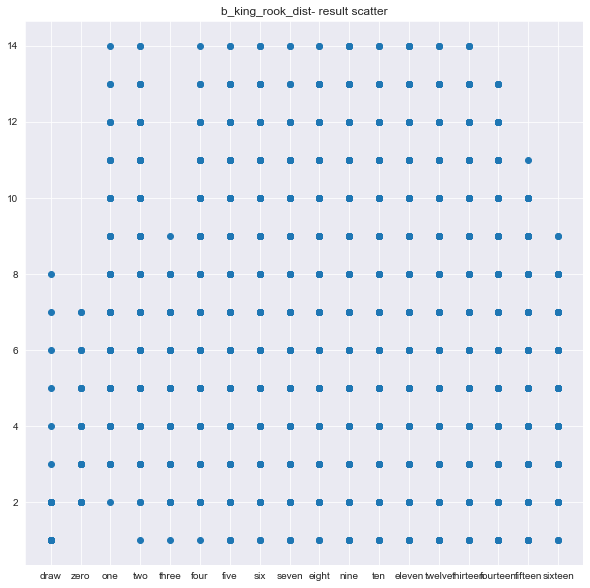

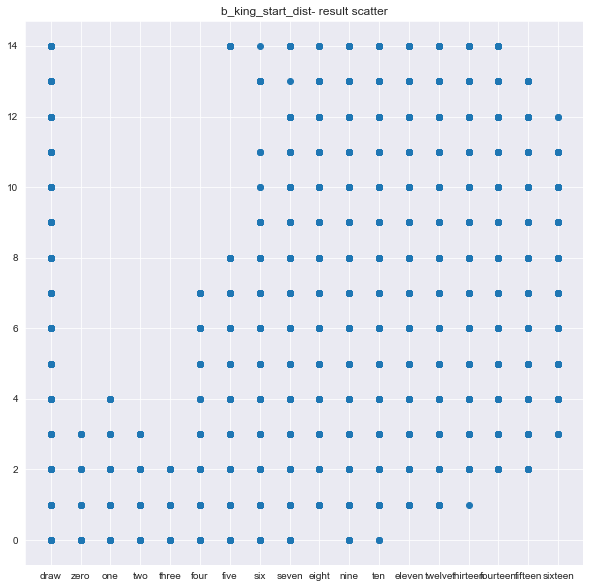

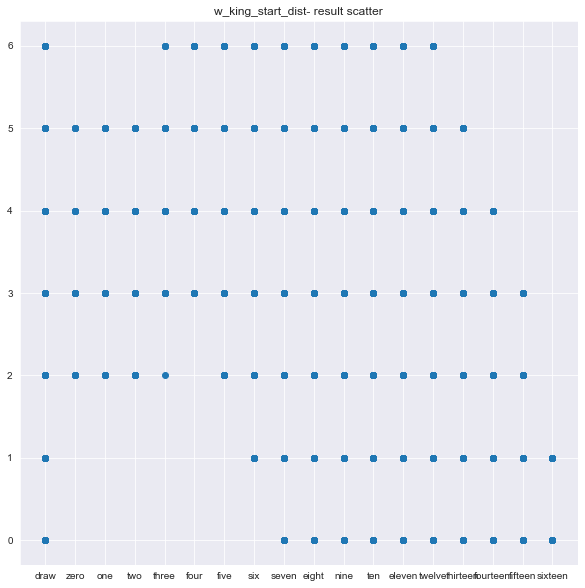

In [16]:
for name in chess_df.columns[-6:]:
    fig, axes = plt.subplots(figsize=(10,10)) 
    axes.scatter(chess_df["result"], chess_df[name])
    plt.title(name + "- result scatter")
    plt.show()




<font size="6"> Wnioski: </font>
 <ul>
  <li> Wykres czarnego króla do startu mówi, że im bliżej do startu tym większa szansa na mata. Odwrotna sytuacja występuje dla białego króla </li>
  <li> Wykres odległości białej wieży do rogu szachownicy mówi nam, że najwięcej rezultatów możemy uzyskać gdy wieża jest na środku. Możliwości wyniku zmniejszają się wraz z odległością wieży od środka </li>
  <li> Wykres odległości białej wieży do białego króla sugeruje, że szanse na mata maleją tym bardziej im bardziej oddalają się od odległości 5 </li>
  <li> Wykres odległości białej wieży do białego króla sugeruje, że szanse na mata maleją tym bardziej im bardziej oddalają się od odległości 5 </li>
  <li> Im bliżej czarny król jest środka tym trudniej doprowadzić do mata </li>
</ul>  
</font>

In [46]:
chess_df.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,distance_from_black_king_to_center,distance_from_white_king_to_white_rook,b_king_rook_dist,w_king_start_dist
0,1,1,2,3,3,2,draw,2.236068,2.236068,2,0
1,1,1,3,1,3,2,draw,2.236068,2.000000,1,0
2,1,1,3,1,4,1,draw,3.000000,2.000000,1,0
3,1,1,3,1,4,2,draw,2.000000,2.000000,2,0
4,1,1,3,2,3,1,draw,3.162278,2.236068,1,0


<font size="4"> W związku ze wstępną poprawnością danych preprosecing będzie polegał jedynie na zakodowaniu etykiet</font>

In [19]:
from sklearn.preprocessing import LabelEncoder
lbl_white_king=LabelEncoder()
chess_df['white_king_file']=lbl_white_king.fit_transform(chess_df['white_king_file'])
lbl_white_rook=LabelEncoder()
chess_df['white_rook_file']=lbl_white_rook.fit_transform(chess_df['white_rook_file'])
lbl_black_king=LabelEncoder()
chess_df['black_king_file']=lbl_black_king.fit_transform(chess_df['black_king_file'])
lbl_result=LabelEncoder()
chess_df['result']=lbl_result.fit_transform(chess_df['result'])
